<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [ ]:
# Set your student number
student_number = 400104686
Name = 'Parsa'
Last_Name = 'Yousefpoor'

# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

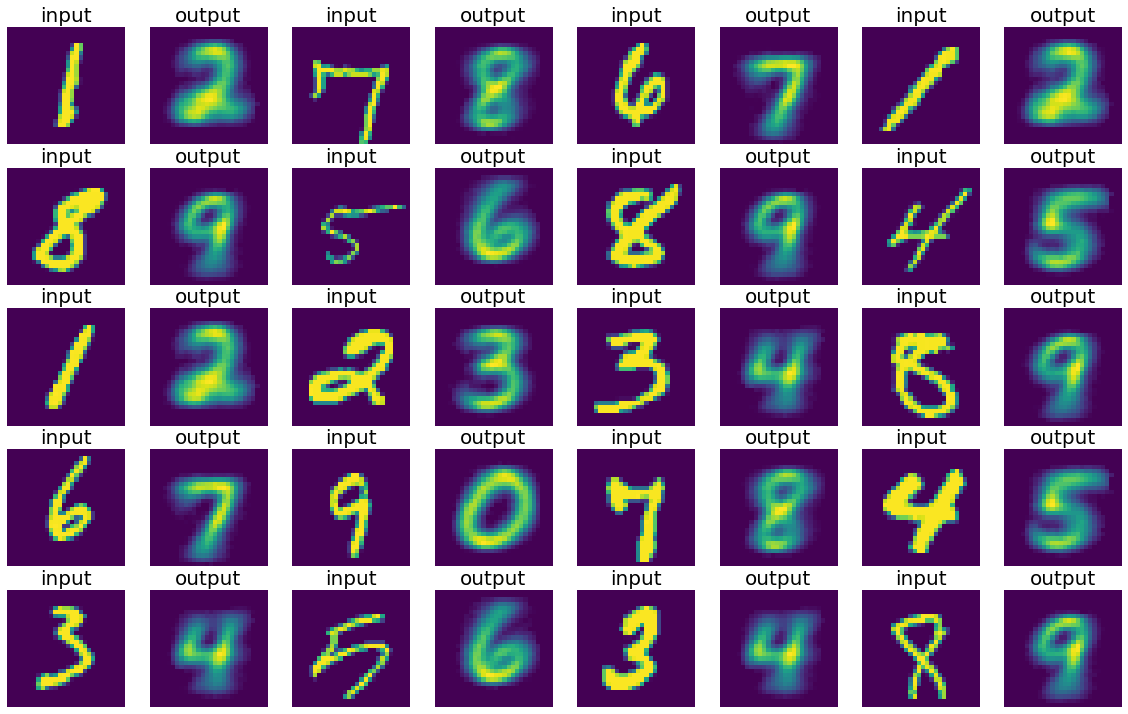

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [1]:
from typing import Tuple

from sklearn.datasets import fetch_openml
import numpy as np
import os
import torch
from tqdm import tqdm


def get_data() -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """ Downloads the MNIST data and processes the data for autoencoder problem.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple of input images,
            output images (input + 1), and the label of input images
    """
    X, y = fetch_openml('mnist_784', return_X_y=True, cache=True)
    X, y = X.values, y.values
    X = X.reshape(-1, 28, 28).astype('float32') / 255.0
    y = y.astype(int)

    Y = np.zeros_like(X)
    ind = y.argsort()
    X, y = X[ind], y[ind]

    c = 0
    for i in range(10):
        s = (y == i).sum()
        ss = (y == (i + 1) % 10).sum()
        if s <= ss:
            Y[c:c+s] = X[c+s:c+2*s]
        elif i < 9:
            Y[c:c+ss] = X[c+s:c+s+ss]
            Y[c+ss:c+s] = X[c+s:c+2*s-ss]
        else:
            Y[c:c+ss] = X[:ss]
            Y[c+ss:c+s] = X[:s-ss]
        c += s

    current_state = np.random.get_state()

    np.random.seed(10)
    ind = np.random.permutation(X.shape[0])
    X, Y, y = X[ind], Y[ind], y[ind]

    np.random.set_state(current_state)

    return X, Y, y

def init_mnist_subset_directories(mnist_dataset, dataset_path, subset_size=5000):
    mnist_subset = torch.utils.data.Subset(mnist_dataset, torch.randperm(len(mnist_dataset))[:subset_size])

    os.mkdir(dataset_path)

    for idx, (x, y) in enumerate(tqdm(mnist_subset)):
        label_path = os.path.join(dataset_path, str(y))
        if not os.path.exists(label_path):
            os.mkdir(label_path)
        torch.save(x, os.path.join(label_path, 'data_'+str(idx)+'.pth'))

In [2]:
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [3]:
#### IMPLEMENT YOUR MODEL ####
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # your code here
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),  # Input size: 28x28 = 784
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16)  # Latent space size
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 784)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # your code here
        x = x.view(x.size(0), -1)

        # Encode
        encoded = self.encoder(x)

        # Decode
        decoded = self.decoder(encoded)

        # Reshape to original image size
        decoded = decoded.view(x.size(0), 1, 28, 28)

        return decoded

# Instantiate the model
autoencoder = AutoEncoder()

# Example usage:
input_batch = torch.randn(32, 1, 28, 28)  # Batch of 32 MNIST images
output_batch = autoencoder(input_batch)
print("Output shape:", output_batch.shape)  # Should be (32, 1, 28, 28)


Output shape: torch.Size([32, 1, 28, 28])


## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [4]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [5]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [6]:
# place for your custom functions for training and evaluation of the autoencoder
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def train_autoencoder(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader) -> float:
    model.train()
    epoch_loss = 0.0
    for batch in dataloader:
        inputs, _, _ = batch
        inputs = inputs.to(device)
        reconstructed = model(inputs)
        loss = F.mse_loss(reconstructed, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss = epoch_loss / len(dataloader)
    return epoch_loss

def eval_autoencoder(model: nn.Module, dataloader: DataLoader) -> float:
    model.eval()
    epoch_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            inputs, _, _ = batch
            inputs = inputs.to(device)
            reconstructed = model(inputs)
            loss = F.mse_loss(reconstructed, inputs)
            epoch_loss += loss.item()
    epoch_loss = epoch_loss / len(dataloader)
    return epoch_loss

## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [7]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####
import torch.optim as optim
ae = AutoEncoder().to(device=device)
learning_rate = 0.001
weight_decay = 1e-5
optimizer = optim.Adam(ae.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [22]:
#### IMPLEMENT YOUR TRAIN/VAL LOOP ####
def train_and_validate_autoencoder(model: nn.Module, optimizer: torch.optim.Optimizer,
                                   train_dataloader: DataLoader, val_dataloader: DataLoader,
                                   num_epochs: int) -> nn.Module:
    best_val_loss = float('inf')
    best_model_state_dict = None

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0

        for batch in train_dataloader:
            inputs, _, _ = batch
            inputs = inputs.to(device)

            optimizer.zero_grad()
            reconstructed = model(inputs)
            temp = torch.unsqueeze(inputs, axis=1)
            loss = F.mse_loss(reconstructed, temp)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_dataloader)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_dataloader:
                inputs, _, _ = batch
                inputs = inputs.to(device)
                reconstructed = model(inputs)
                temp = torch.unsqueeze(inputs, axis=1)
                loss = F.mse_loss(reconstructed, temp)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)

        # Log metrics
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

        # Check if this is the best model so far
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state_dict = model.state_dict()

    # Load the best model state dict
    model.load_state_dict(best_model_state_dict)
    print("Training complete. Best validation loss:", best_val_loss)
    return model

# Set hyperparameters
num_epochs = 10 # You can adjust this as needed

# Train and validate the autoencoder
trained_autoencoder = train_and_validate_autoencoder(ae, optimizer, train_dataloader, val_dataloader, num_epochs)

Epoch [1/2] - Train Loss: 0.0281 - Val Loss: 0.0273
Epoch [2/2] - Train Loss: 0.0263 - Val Loss: 0.0258
Training complete. Best validation loss: 0.02582417211184899


## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [23]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####
from copy import deepcopy
# Load the best epoch state dictionary
def load_best_model(model, path="best_model.pth"):
  """
  Loads the best model state dictionary from the specified path.

  Args:
      model: The model to load the state dictionary into.
      path: The path to the saved state dictionary (default: "best_model.pth").

  Returns:
      The model with the loaded state dictionary.
  """
  if os.path.exists(path):
    model.load_state_dict(torch.load(path))
    print("Loaded best model state dictionary from", path)
  else:
    print("Best model state dictionary not found at", path)
  return model

# Load the best model state dictionary (optional, you can set a path if you saved it)
loaded_model = load_best_model(deepcopy(trained_autoencoder))

Best model state dictionary not found at best_model.pth


## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

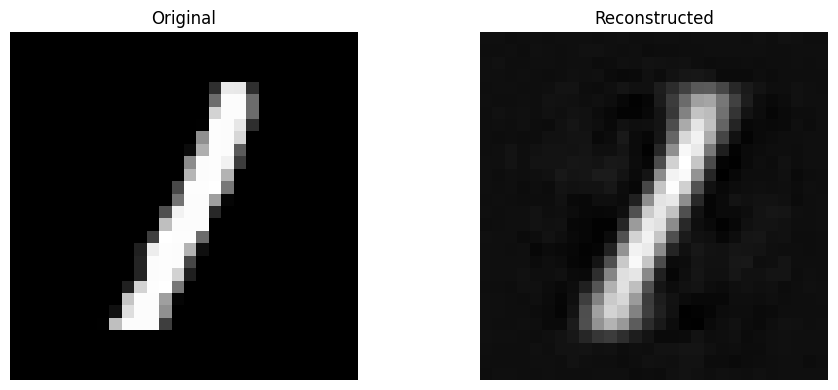

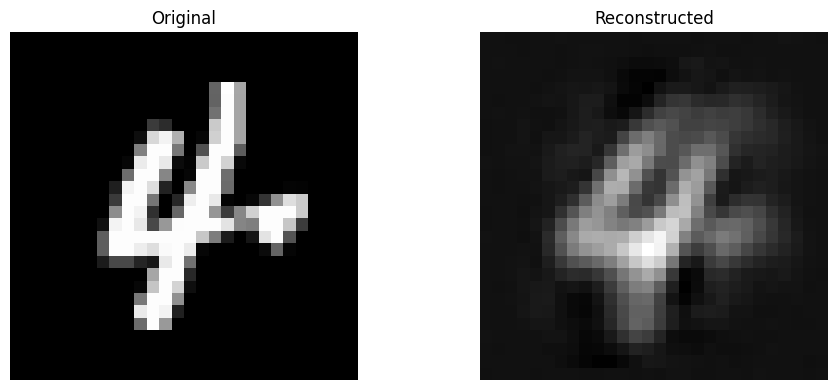

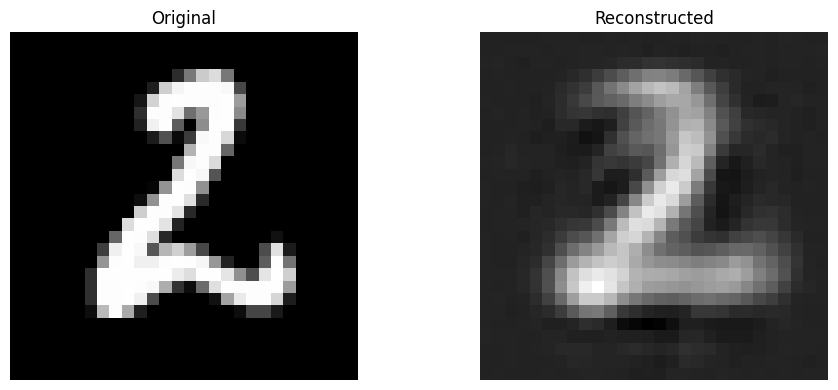

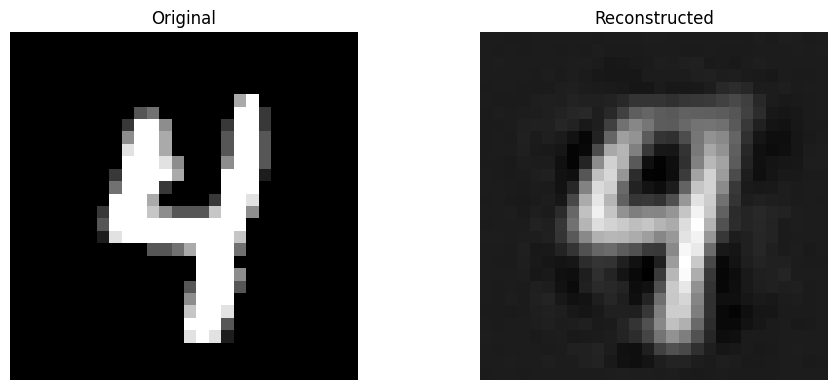

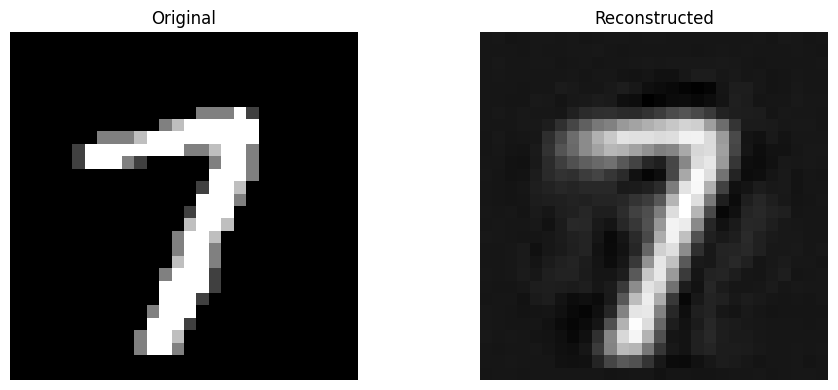

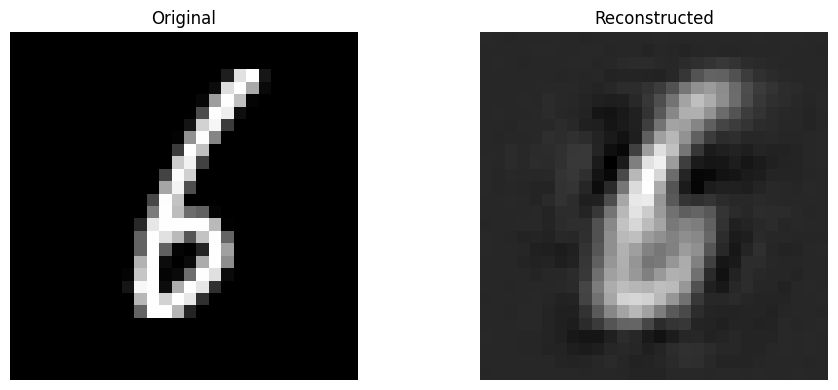

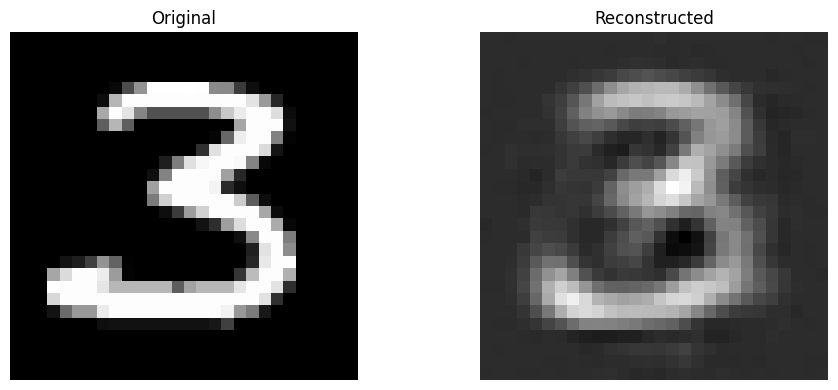

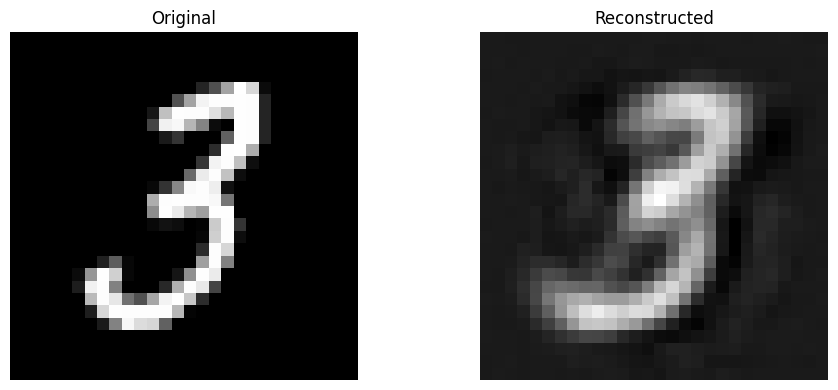

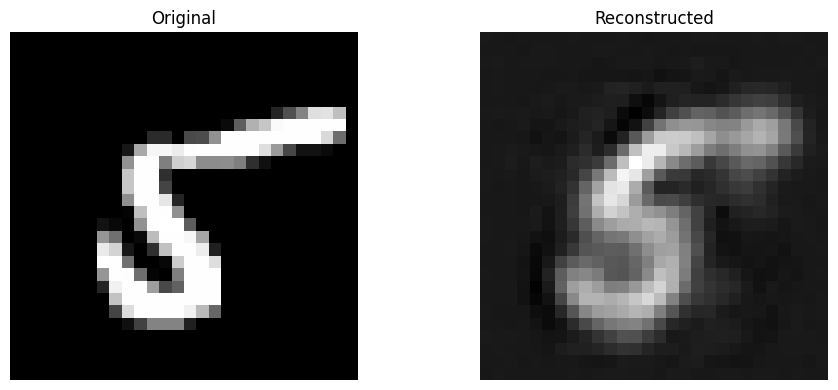

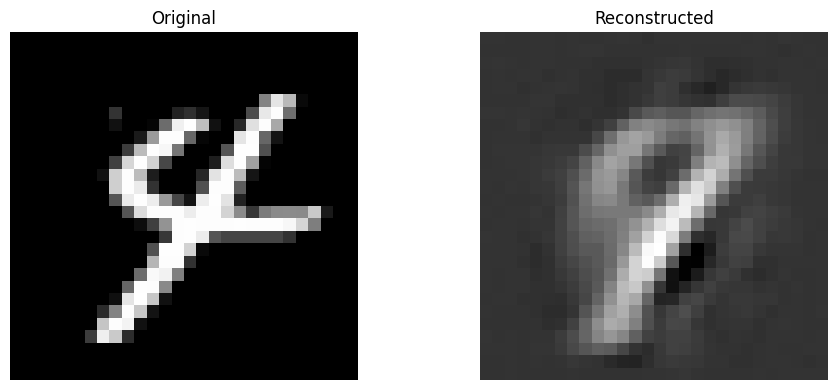

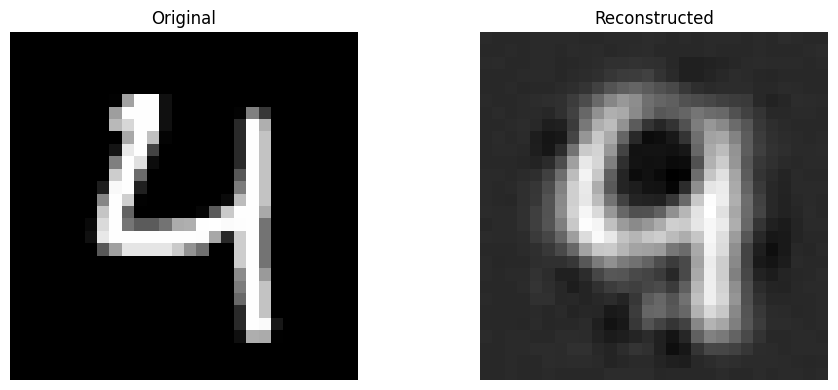

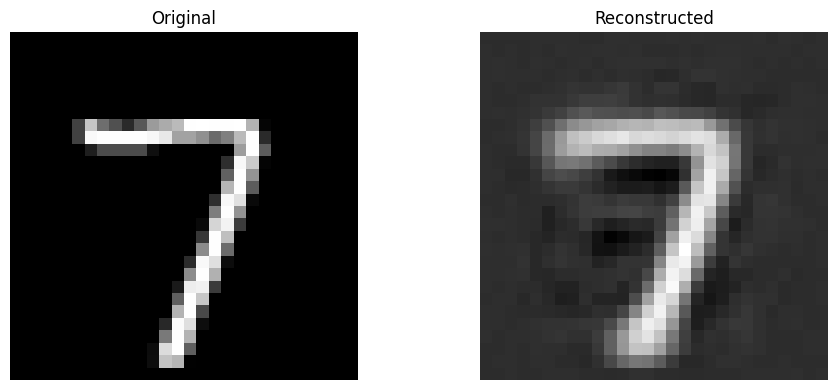

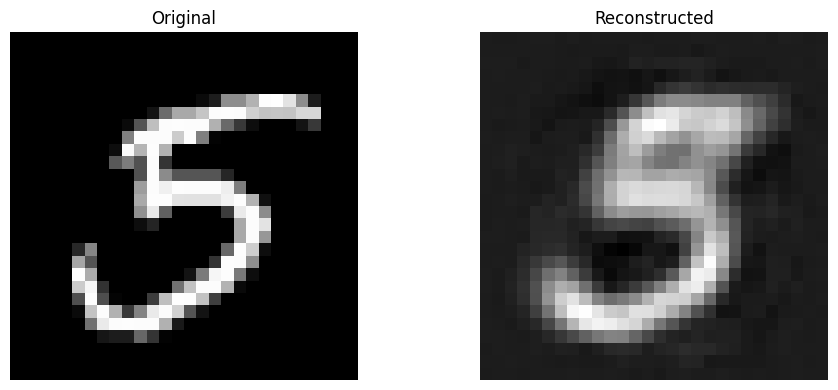

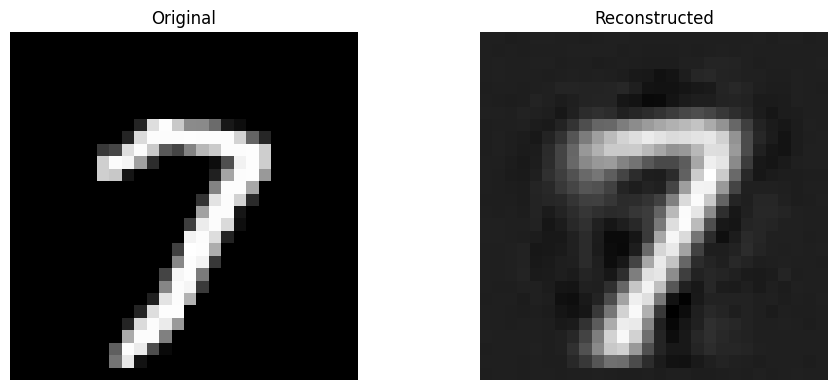

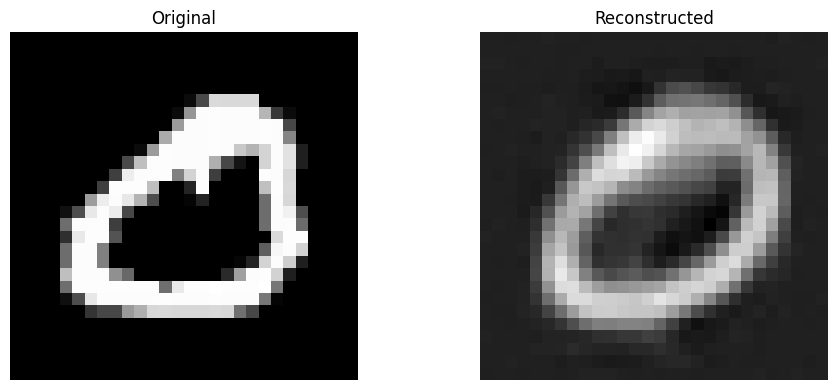

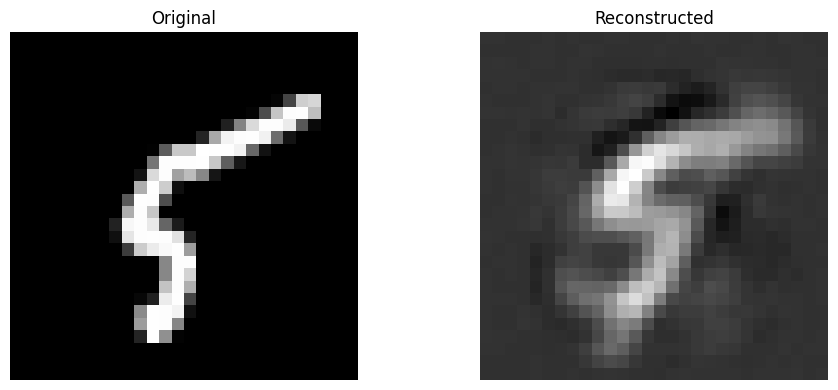

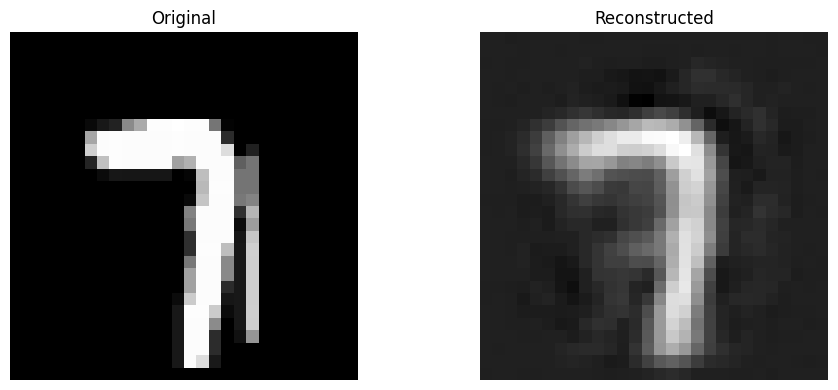

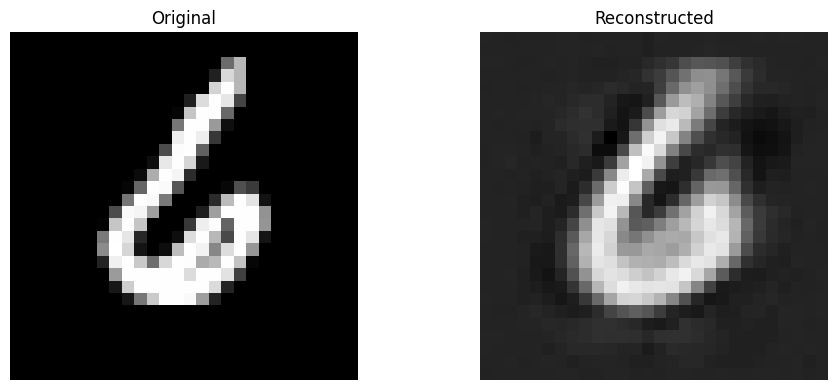

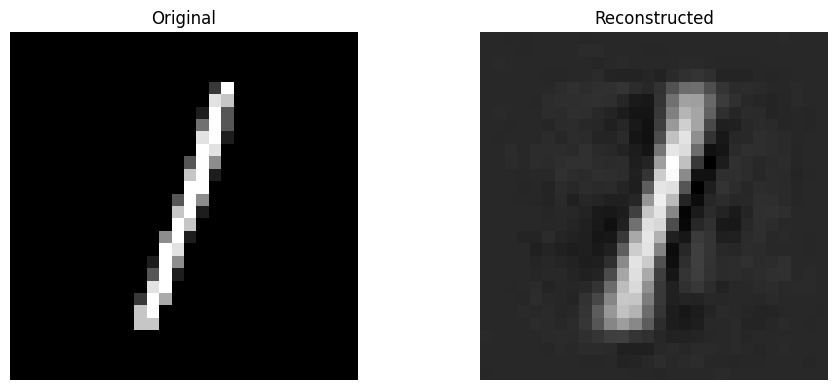

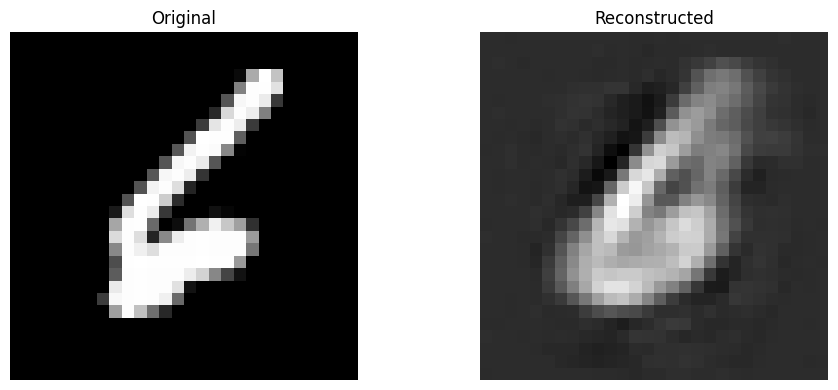

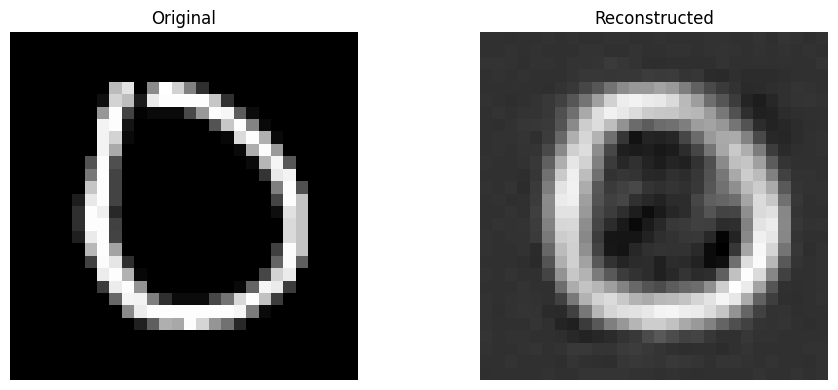

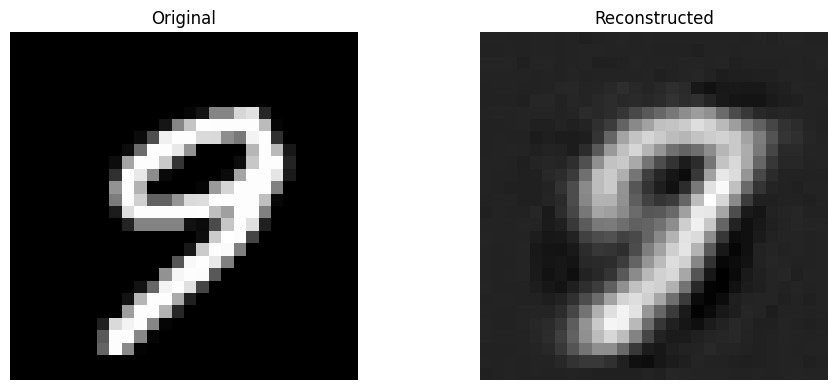

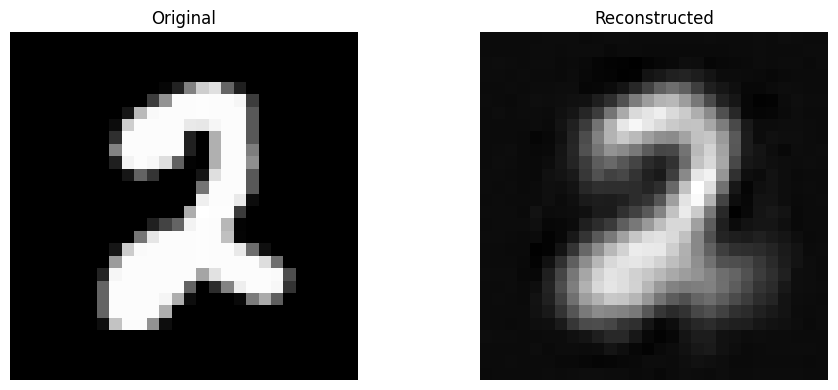

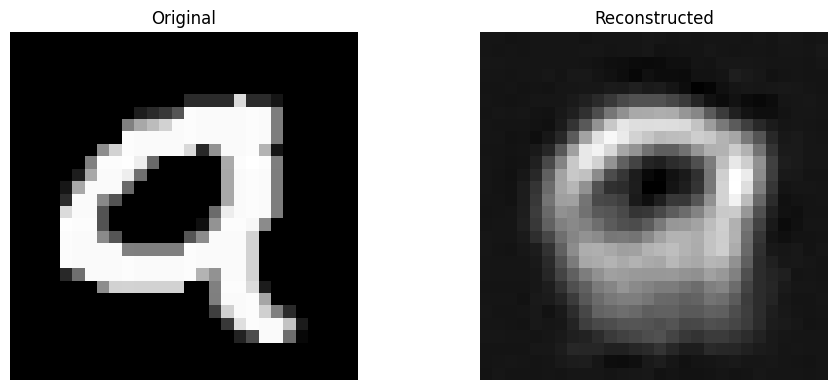

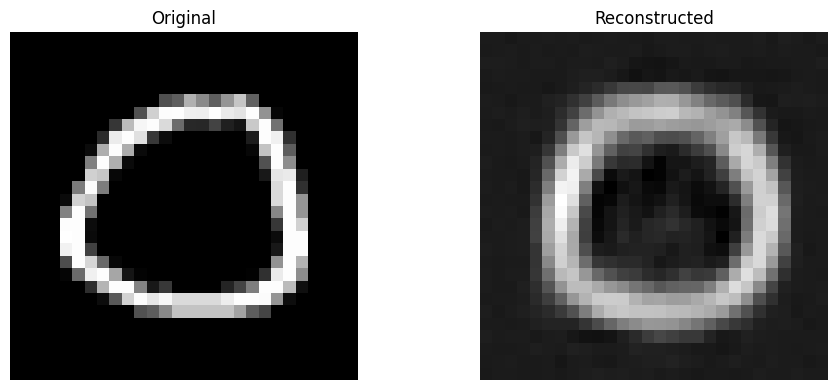

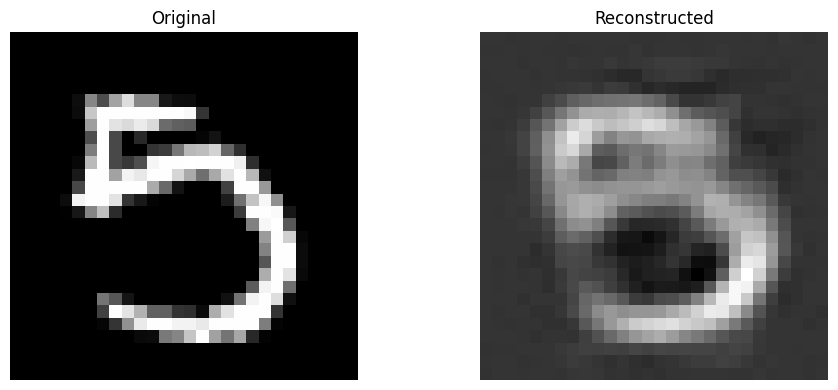

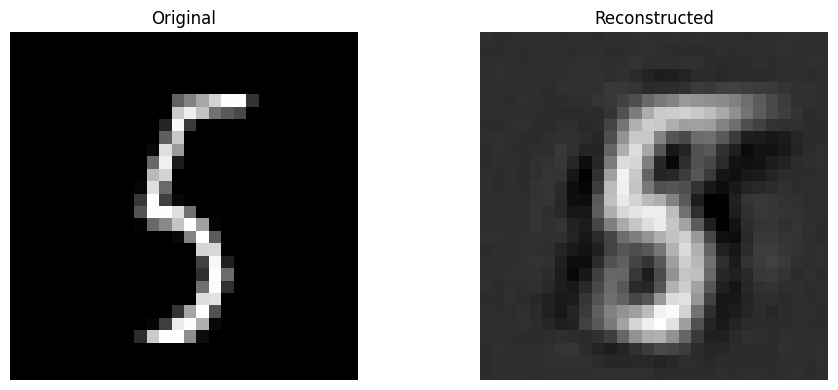

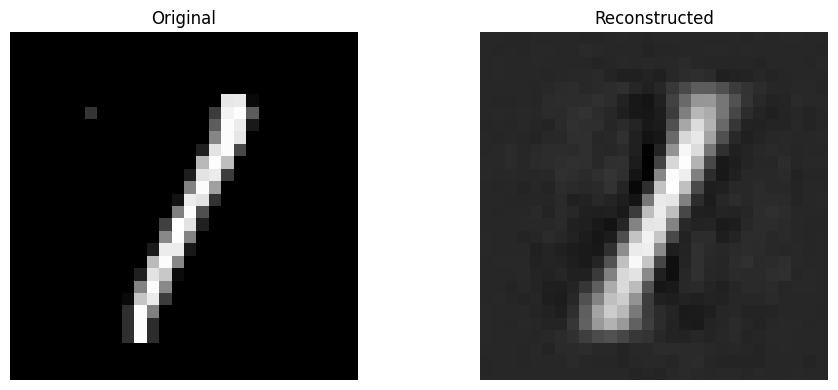

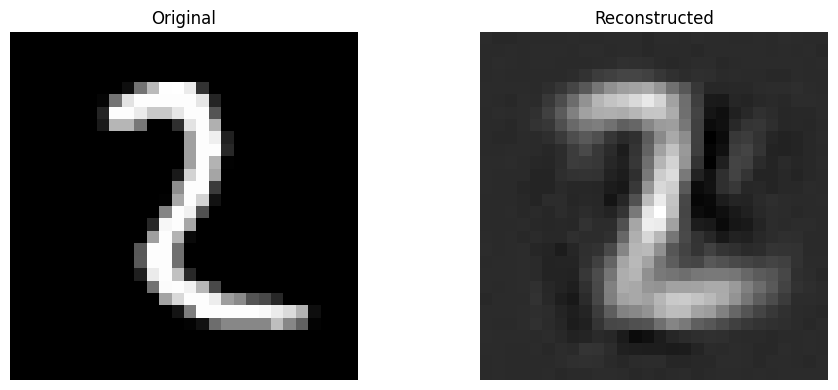

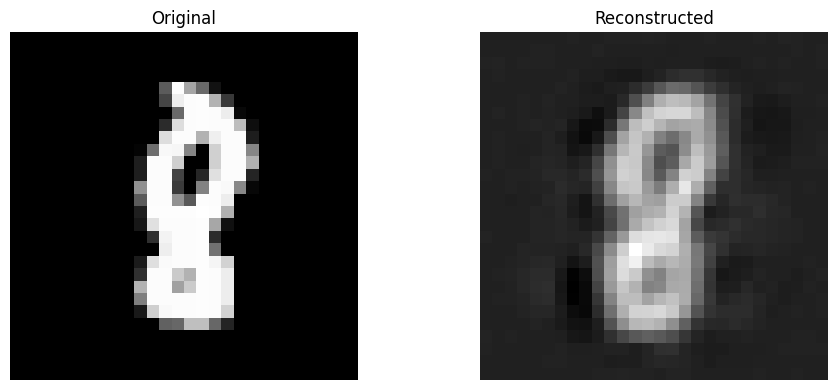

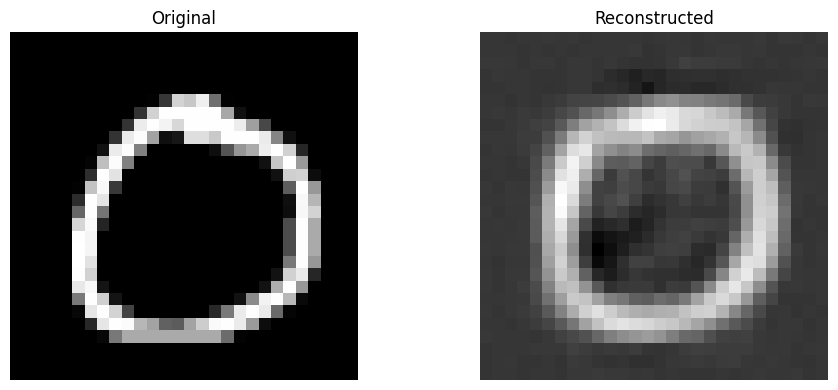

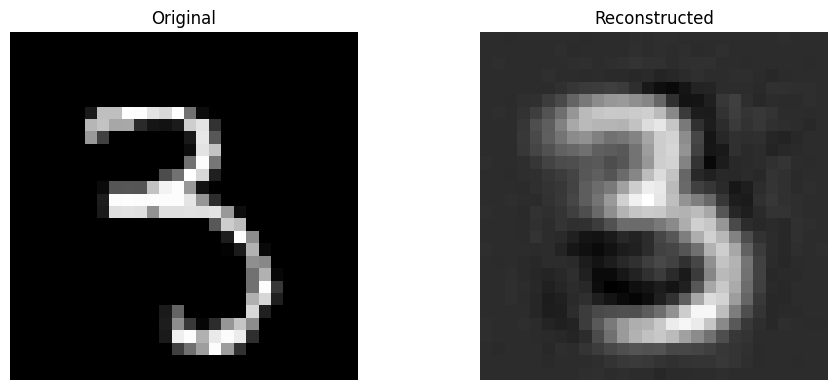

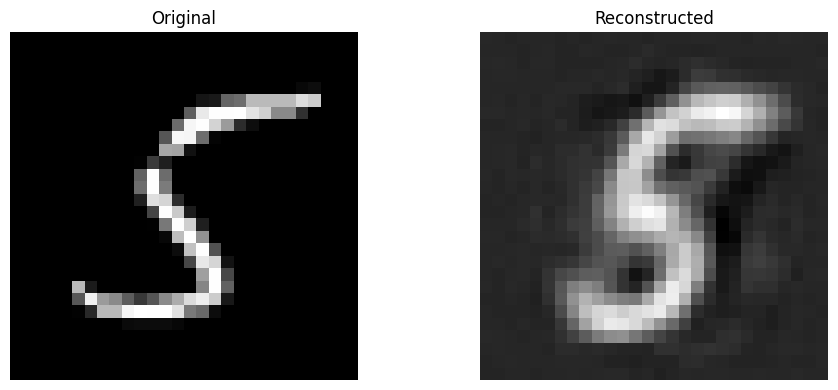

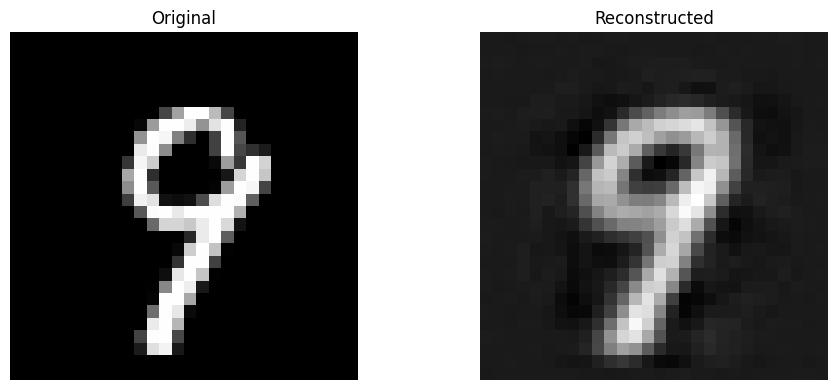

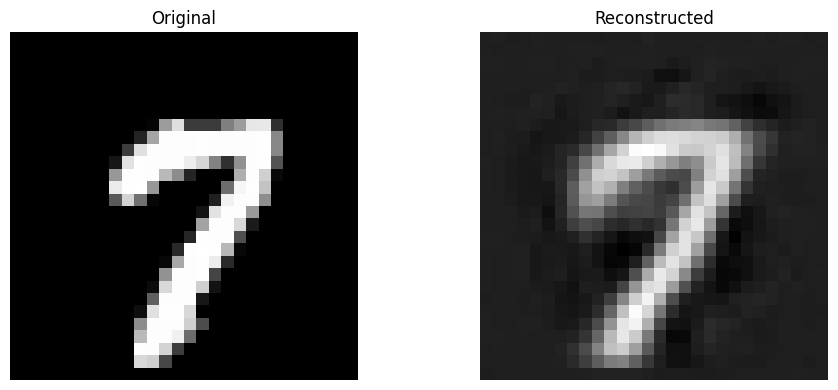

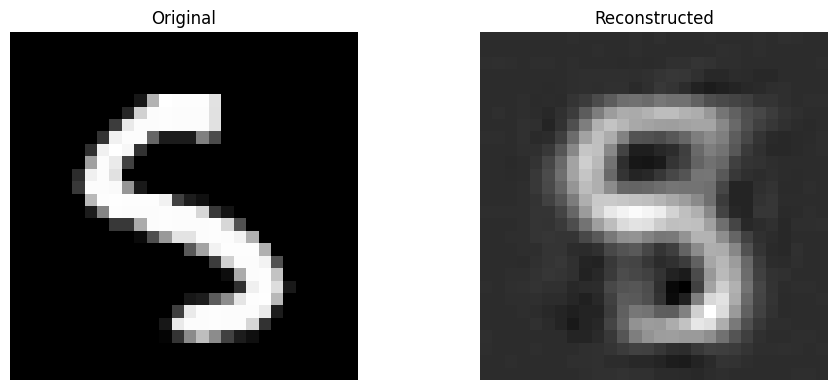

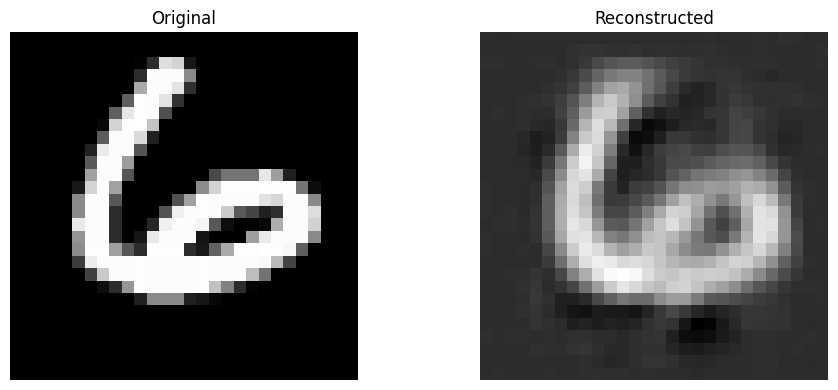

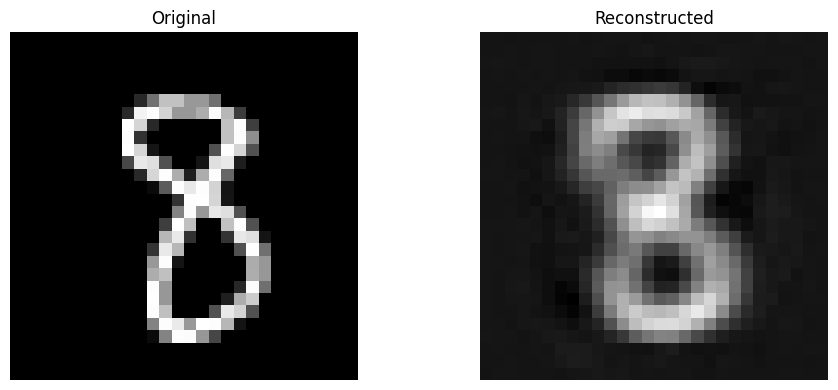

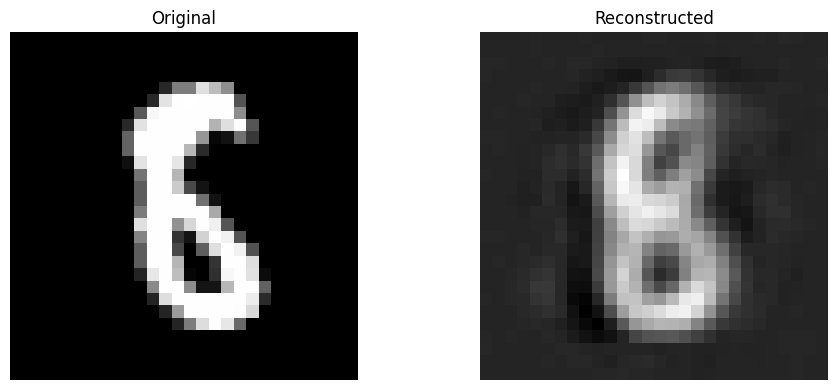

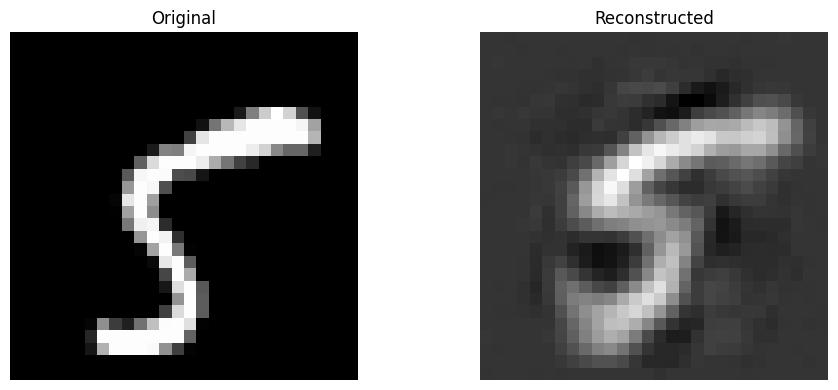

In [24]:
#### VISUALIZE YOUR MODEL ####
# Visualize input and output
def visualize_input_output(model, test_dataloader, num_examples=40):
  """
  Visualizes the input and output of the model for a given number of examples from the test set.

  Args:
      model: The trained autoencoder model.
      test_dataloader: The test data loader.
      num_examples: The number of examples to visualize (default: 40).
  """
  model.eval()
  import matplotlib.pyplot as plt

  with torch.no_grad():
    for i, (inputs, targets, _) in enumerate(test_dataloader):
      if i >= num_examples:
        break
      inputs = inputs.to(device)
      reconstructed = model(inputs)

      # Convert tensors to numpy arrays for plotting
      original_images = inputs.cpu().numpy()
      reconstructed_images = reconstructed.cpu().numpy()

      # Reshape back to image dimensions
      original_images = original_images.reshape(-1, 28, 28)
      reconstructed_images = reconstructed_images.reshape(-1, 28, 28)

      # Plot the original and reconstructed images side-by-side
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
      ax1.imshow(original_images[i], cmap="gray")
      ax1.set_title("Original")
      ax1.axis("off")
      ax2.imshow(reconstructed_images[i], cmap="gray")
      ax2.set_title("Reconstructed")
      ax2.axis("off")
      plt.tight_layout()
      plt.show()

test_dataset = MnistNextDigitDataset(X_test, Y_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)  # Adjust batch size as needed

# Visualize input and output on test set
visualize_input_output(loaded_model, test_dataloader)